In [1]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, Dataset
from torchvision import datasets, transforms
from tqdm import tqdm
import os
from PIL import Image

class ImageFolderDataset(Dataset):
    def __init__(self, root_dir, transform=None):
        self.root_dir = root_dir
        self.transform = transform
        self.images = [img for img in os.listdir(root_dir) if img.endswith(".jpg")]

    def __len__(self):
        return len(self.images)

    def __getitem__(self, idx):
        img_name = os.path.join(self.root_dir, self.images[idx])
        image = Image.open(img_name).convert('RGB')

        if self.transform:
            image = self.transform(image)

        return image

# Defining my datasets and dataloaders
transform = transforms.Compose([
    transforms.Resize((256, 256)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.5, 0.5, 0.5], std=[0.5, 0.5, 0.5])
])

split_size = 0.8

# Defining my datasets and dataloaders
horse_dataset = ImageFolderDataset(root_dir='/kaggle/input/horse2zebra-dataset/trainA/', transform=transforms.ToTensor())
zebra_dataset = ImageFolderDataset(root_dir='/kaggle/input/horse2zebra-dataset/trainB/', transform=transforms.ToTensor())

train_size_horse = int(split_size * len(horse_dataset))
val_size_horse = len(horse_dataset) - train_size_horse
train_dataset_horse, val_dataset_horse = torch.utils.data.random_split(horse_dataset, [train_size_horse, val_size_horse])

train_size_zebra = int(split_size * len(zebra_dataset))
val_size_zebra = len(zebra_dataset) - train_size_zebra
train_dataset_zebra, val_dataset_zebra = torch.utils.data.random_split(zebra_dataset, [train_size_zebra, val_size_zebra])


train_horse_loader = DataLoader(train_dataset_horse, batch_size=1, shuffle=True, num_workers=2)
val_horse_loader = DataLoader(val_dataset_horse, batch_size=1, shuffle=True, num_workers=2)

train_zebra_loader = DataLoader(train_dataset_zebra, batch_size=1, shuffle=True, num_workers=2)
val_zebra_loader = DataLoader(val_dataset_zebra, batch_size=1, shuffle=True, num_workers=2)

In [2]:
def visualize_images(real_A, real_B, fake_A, fake_B):
    fig, axes = plt.subplots(2, 2, figsize=(8, 8))
    axes[0, 0].imshow(np.transpose(real_A, (1, 2, 0)))
    axes[0, 0].set_title('Real Image A')
    axes[0, 0].axis('off')

    axes[0, 1].imshow(np.transpose(fake_B, (1, 2, 0)))
    axes[0, 1].set_title('Generated Image B')
    axes[0, 1].axis('off')

    axes[1, 0].imshow(np.transpose(real_B, (1, 2, 0)))
    axes[1, 0].set_title('Real Image B')
    axes[1, 0].axis('off')

    axes[1, 1].imshow(np.transpose(fake_A, (1, 2, 0)))
    axes[1, 1].set_title('Generated Image A')
    axes[1, 1].axis('off')

    plt.show()

In [3]:
import torch.nn as nn

class ResidualBlock(nn.Module):
    def __init__(self, in_channels, out_channels, stride=1):
        super(ResidualBlock, self).__init__()
        self.conv1 = nn.Conv2d(in_channels, out_channels, kernel_size=3, stride=stride, padding=1, bias=False)
        self.inst_norm1 = nn.InstanceNorm2d(out_channels, affine=True)
        self.relu = nn.ReLU(inplace=True)
        self.conv2 = nn.Conv2d(out_channels, out_channels, kernel_size=3, stride=1, padding=1, bias=False)
        self.inst_norm2 = nn.InstanceNorm2d(out_channels, affine=True)

    def forward(self, x):
        residual = x
        out = self.conv1(x)
        out = self.inst_norm1(out)
        out = self.relu(out)
        out = self.conv2(out)
        out = self.inst_norm2(out)
        out += residual
        return out

class Generator(nn.Module):
    def __init__(self):
        super(Generator, self).__init__()

        # Encoder
        self.enc_conv1 = nn.Conv2d(3, 64, kernel_size=7, stride=1, padding=3)
        self.enc_inst_norm1 = nn.InstanceNorm2d(64, affine=True)
        self.relu = nn.ReLU(inplace=True)

        self.enc_conv2 = nn.Conv2d(64, 128, kernel_size=3, stride=2, padding=1)
        self.enc_inst_norm2 = nn.InstanceNorm2d(128, affine=True)

        self.enc_conv3 = nn.Conv2d(128, 256, kernel_size=3, stride=2, padding=1)
        self.enc_inst_norm3 = nn.InstanceNorm2d(256, affine=True)

        # Residual blocks
        self.residual_blocks = nn.Sequential(
            ResidualBlock(256, 256),
            ResidualBlock(256, 256),
            ResidualBlock(256, 256),
            ResidualBlock(256, 256),
            ResidualBlock(256, 256)
        )

        # Decoder
        self.dec_conv1 = nn.ConvTranspose2d(256, 128, kernel_size=3, stride=2, padding=1, output_padding=1)
        self.dec_inst_norm1 = nn.InstanceNorm2d(128, affine=True)

        self.dec_conv2 = nn.ConvTranspose2d(128, 64, kernel_size=3, stride=2, padding=1, output_padding=1)
        self.dec_inst_norm2 = nn.InstanceNorm2d(64, affine=True)

        self.dec_conv3 = nn.Conv2d(64, 3, kernel_size=7, stride=1, padding=3)
        self.dec_tanh = nn.Tanh()

    def forward(self, x):
        # Encoder
        enc1 = self.relu(self.enc_inst_norm1(self.enc_conv1(x)))
        enc2 = self.relu(self.enc_inst_norm2(self.enc_conv2(enc1)))
        enc3 = self.relu(self.enc_inst_norm3(self.enc_conv3(enc2)))

        # Residual blocks
        residual = self.residual_blocks(enc3)

        # Decoder
        dec1 = self.relu(self.dec_inst_norm1(self.dec_conv1(residual)))
        dec2 = self.relu(self.dec_inst_norm2(self.dec_conv2(dec1)))
        output = self.dec_tanh(self.dec_conv3(dec2))

        return output

class Discriminator(nn.Module):
    def __init__(self):
        super(Discriminator, self).__init__()

        self.conv1 = nn.Conv2d(3, 64, kernel_size=4, stride=2, padding=1)
        self.leaky_relu = nn.LeakyReLU(0.2, inplace=True)

        self.conv2 = nn.Conv2d(64, 128, kernel_size=4, stride=2, padding=1)
        self.inst_norm2 = nn.InstanceNorm2d(128, affine=True)

        self.conv3 = nn.Conv2d(128, 256, kernel_size=4, stride=2, padding=1)
        self.inst_norm3 = nn.InstanceNorm2d(256, affine=True)

        self.conv4 = nn.Conv2d(256, 1, kernel_size=4, stride=1, padding=1)

    def forward(self, x):
        x = self.leaky_relu(self.conv1(x))
        x = self.leaky_relu(self.inst_norm2(self.conv2(x)))
        x = self.leaky_relu(self.inst_norm3(self.conv3(x)))
        x = self.conv4(x)
        return x

In [4]:
# Initialize generators and discriminators
import itertools
import matplotlib.pyplot as plt
G_horse2zebra = Generator()
G_zebra2horse = Generator()
D_horse = Discriminator()
D_zebra = Discriminator()

# Define optimizers for generators and discriminators
optimizer_G = optim.Adam(itertools.chain(G_horse2zebra.parameters(), G_zebra2horse.parameters()), lr=0.0002, betas=(0.5, 0.999))
optimizer_D_horse = optim.Adam(D_horse.parameters(), lr=0.0002, betas=(0.5, 0.999))
optimizer_D_zebra = optim.Adam(D_zebra.parameters(), lr=0.0002, betas=(0.5, 0.999))

# Loss functions
criterion_GAN = nn.BCEWithLogitsLoss()
criterion_cycle = nn.L1Loss()

  0%|          | 1/214 [00:01<05:31,  1.56s/it]

Content Loss A: 0.37971124053001404, Content Loss B: 0.6066667437553406


  1%|          | 2/214 [00:02<05:10,  1.46s/it]

Content Loss A: 0.3951364755630493, Content Loss B: 0.4609133303165436


  1%|▏         | 3/214 [00:04<04:58,  1.42s/it]

Content Loss A: 0.37401437759399414, Content Loss B: 0.6140482425689697


  2%|▏         | 4/214 [00:05<05:10,  1.48s/it]

Content Loss A: 0.510351836681366, Content Loss B: 0.6012677550315857


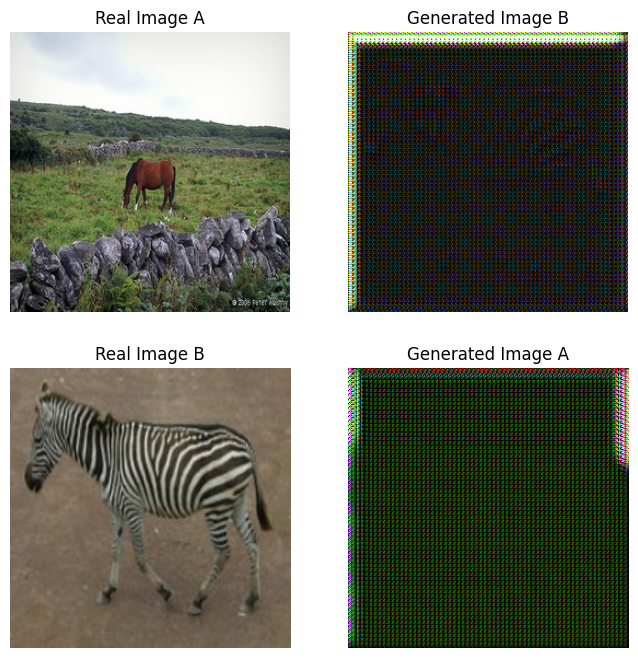

Epoch [0/2] - Loss_G: 18.709003448486328 - Loss_D: 0.0005386682460084558


  0%|          | 1/214 [00:01<05:57,  1.68s/it]

Content Loss A: 0.5625633597373962, Content Loss B: 0.5582084059715271


  1%|          | 2/214 [00:03<05:14,  1.48s/it]

Content Loss A: 0.5428416132926941, Content Loss B: 0.5866947770118713


  1%|▏         | 3/214 [00:04<04:53,  1.39s/it]

Content Loss A: 0.48772311210632324, Content Loss B: 0.49588119983673096


  2%|▏         | 4/214 [00:05<04:54,  1.40s/it]

Content Loss A: 0.4432919919490814, Content Loss B: 0.5172870755195618


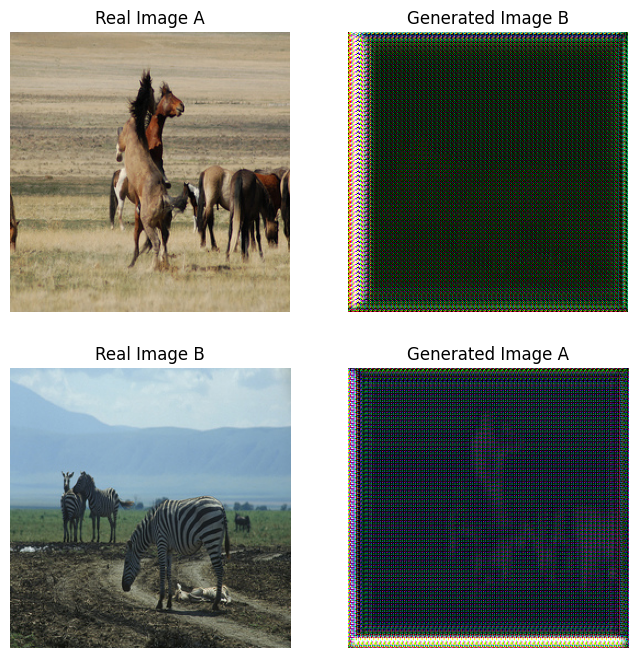

Epoch [1/2] - Loss_G: 21.27770233154297 - Loss_D: 0.00015265203546732664


In [5]:

import numpy as np
# Training loop
num_epochs = 2

for epoch in range(num_epochs):
    for horse_data, zebra_data in tqdm(zip(train_horse_loader, train_zebra_loader), total=len(train_horse_loader)):
        # Training the discriminators
        optimizer_D_horse.zero_grad()
        optimizer_D_zebra.zero_grad()

        # Forward pass through generators
        fake_zebra = G_horse2zebra(horse_data)
        fake_horse = G_zebra2horse(zebra_data)

        # Adversarial loss
        loss_D_horse = criterion_GAN(D_horse(horse_data), torch.zeros_like(D_horse(horse_data)))
        loss_D_zebra = criterion_GAN(D_zebra(zebra_data), torch.zeros_like(D_zebra(zebra_data)))

        loss_D_fake_horse = criterion_GAN(D_horse(fake_horse.detach()), torch.zeros_like(D_horse(fake_horse)))
        loss_D_fake_zebra = criterion_GAN(D_zebra(fake_zebra.detach()), torch.zeros_like(D_zebra(fake_zebra)))

        loss_D = 0.5 * (loss_D_horse + loss_D_fake_horse) + 0.5 * (loss_D_zebra + loss_D_fake_zebra)
        loss_D.backward()
        optimizer_D_horse.step()
        optimizer_D_zebra.step()

        # Training the generators
        optimizer_G.zero_grad()

        # Adversarial loss
        loss_G_horse = criterion_GAN(D_horse(fake_horse), torch.ones_like(D_horse(fake_horse)))
        loss_G_zebra = criterion_GAN(D_zebra(fake_zebra), torch.ones_like(D_zebra(fake_zebra)))

        # Cycle consistency loss
        reconstructed_horse = G_zebra2horse(fake_zebra)
        reconstructed_zebra = G_horse2zebra(fake_horse)

        loss_cycle_horse = criterion_cycle(reconstructed_horse, horse_data)
        loss_cycle_zebra = criterion_cycle(reconstructed_zebra, zebra_data)

        loss_G = loss_G_horse + loss_G_zebra + 10 * (loss_cycle_horse + loss_cycle_zebra)
        loss_G.backward()
        optimizer_G.step()
        
    with torch.no_grad():
        generated_images_A = []
        generated_images_B = []
        real_images_A = []
        real_images_B = []

        for val_data_A, val_data_B in tqdm(zip(val_horse_loader, val_zebra_loader), total=len(val_horse_loader)):
            if len(generated_images_A) > 3:
                break
                
            x_val_A = val_data_A
            x_val_B = val_data_B

            # Forward pass through the generators
            fake_B = G_horse2zebra(x_val_A)
            fake_A = G_zebra2horse(x_val_B)
            
            content_loss_A = criterion_cycle(G_zebra2horse(x_val_B), x_val_B)
            content_loss_B = criterion_cycle(G_horse2zebra(x_val_A), x_val_A)
            
            print(f"Content Loss A: {content_loss_A.item()}, Content Loss B: {content_loss_B.item()}")

            # Accumulate generated and real images for later visualization
            generated_images_A.append(fake_B.cpu().detach().squeeze(0))
            generated_images_B.append(fake_A.cpu().detach().squeeze(0))
            real_images_A.append(x_val_A.cpu().detach().squeeze(0))
            real_images_B.append(x_val_B.cpu().detach().squeeze(0))

        # Visualize a sample of generated and real images
        visualize_images(
            real_A=real_images_A[0], 
            real_B=real_images_B[0], 
            fake_A=generated_images_A[0], 
            fake_B=generated_images_B[0]
        )


    # Print or log the losses for monitoring the training process
    print(f"Epoch [{epoch}/{num_epochs}] - Loss_G: {loss_G.item()} - Loss_D: {loss_D.item()}")
    
    

In [6]:
# Save the trained models if needed
torch.save(G_horse2zebra.state_dict(), 'G_horse2zebra.pth')
torch.save(G_zebra2horse.state_dict(), 'G_zebra2horse.pth')
torch.save(D_horse.state_dict(), 'D_horse.pth')
torch.save(D_zebra.state_dict(), 'D_zebra.pth')
